## Topic Modelling

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the dataset

In [9]:
df = pd.read_pickle("trove_overproof/db_trove.pkl")

In [10]:
df.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected,str_similarity,str_length,quality_band
1,./trove_overproof/datasets/dataset1/rawTextAnd...,18378453,Article ILLUSTRATED,1953,"FROM RIVER CROSSING TO END OF TRIÄÜ I ^PI A^H""...",FROM RIVER CROSSING TO END OF TRIAL SPLASH: Pe...,,0.847747,747,2
2,./trove_overproof/datasets/dataset1/rawTextAnd...,18363627,Article,1953,"Natural Childbirth Sir,-We nurses have seen fa...","Natural Childbirth Sir,-We nurses have seen fa...",,0.964174,642,1
3,./trove_overproof/datasets/dataset1/rawTextAnd...,18366055,Article,1953,FIRST CHURCH I SERVICE 1 Presbyterian I ' Anni...,FIRST CHURCH SERVICE Presbyterian Anniversary ...,,0.739176,947,3
4,./trove_overproof/datasets/dataset1/rawTextAnd...,18386137,Article,1953,"""Bob"" Lulham's Fight Against Thallium District...","""Bob"" Lulham's Fight Against Thallium Arthur ...",,0.493898,2950,4
5,./trove_overproof/datasets/dataset1/rawTextAnd...,18368961,Article,1953,"DIVORCE Before The Judge In Divorce, Mr Justic...","DIVORCE Before The Judge In Divorce, Mr. Justi...",,0.894262,1220,2


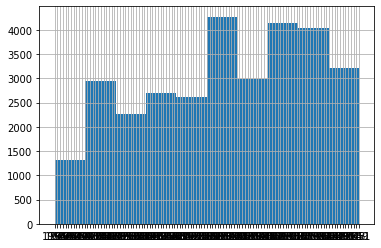

In [11]:
df["year"].hist()

In [12]:
df = df.astype({'filePath': 'str', 'articleId': 'str', 'articleType': 'category', 'year': 'int32', 'ocrText': 'str', 'humanText': 'str', 'corrected': 'str',
               'str_similarity': 'float32', 'str_length': 'int32', 'quality_band': 'int32'})
df.describe()

,year,str_similarity,str_length,quality_band
count,30509.000000,30509.000000,30509.000000,30509.000000
mean,1904.897112,0.861103,1883.680357,1.839490
std,21.922963,0.082354,1241.521432,0.814654
min,1842.000000,0.055964,309.000000,1.000000
25%,1892.000000,0.830619,918.000000,1.000000
50%,1903.000000,0.882869,1462.000000,2.000000
75%,1922.000000,0.915927,2528.000000,2.000000
max,1954.000000,0.999446,10633.000000,4.000000


### Pre-processing

In [6]:
!python -m spacy download en


    Linking successful
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/en_core_web_sm -->
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [74]:
sample_size = 3000

sample_human = df["humanText"].sample(n=sample_size, random_state=seed)
sample_ocr = df["ocrText"].sample(n=sample_size, random_state=seed)

In [75]:
sample_human[:2]

2405     SHIPPING INTELLIGENCE. ______ ARRIVALS. JUNE 2...
29144    COMMONWEALTH NOTES.  THE FEDERAL TARIFF. (BY O...
Name: humanText, dtype: object

In [76]:
sample_ocr[:2]

2405     SHIPPING IN TELLIG Rf! 4^ - inca ARRIVALS. . -...
29144    COMMONWEALTH NOTES. .-? THE FEDERAL TARIFF. (B...
Name: ocrText, dtype: object

In [80]:
%%time
nlp = spacy.load('en')
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(sample_ocr, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    #ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    #doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)

CPU times: user 10min 2s, sys: 1min 21s, total: 11min 23s
Wall time: 2min 56s


In [81]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear 25 times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [82]:
# CHANGE this
#docs_human = docs
docs_ocr = docs

In [109]:
# save corpora
import pickle

with open('trove_overproof/docs_human.pkl', 'wb') as handle:
    pickle.dump(docs_human, handle)
with open('trove_overproof/docs_ocr.pkl', 'wb') as handle:
    pickle.dump(docs_ocr, handle)

In [ ]:
# load corpora
import pickle

docs_human = list()
docs_ocr = list()

with open('trove_overproof/docs_human.pkl', 'rb') as handle:
    docs_human = pickle.load(handle)
with open('trove_overproof/docs_ocr.pkl', 'rb') as handle:
    docs_ocr = pickle.load(handle)

In [27]:
# there is a duplicate from here on: change after experiments

In [92]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_human = Dictionary(docs_human)
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary_human.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_human = [dictionary_human.doc2bow(doc) for doc in docs_human]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_human))
print('Number of docs: %d' % len(corpus_human))

Number of unique tokens: 8497
Number of docs: 3000


In [93]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_ocr = Dictionary(docs_ocr)
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary_ocr.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_ocr = [dictionary_ocr.doc2bow(doc) for doc in docs_ocr]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_ocr))
print('Number of docs: %d' % len(corpus_ocr))

Number of unique tokens: 10489
Number of docs: 3000


### LDA

In [196]:
%%time

from gensim.models import LdaMulticore
params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model_human = LdaMulticore(corpus=corpus_human, num_topics=params['num_topics'], id2word=dictionary_human, workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 23.7 s, sys: 2.59 s, total: 26.2 s
Wall time: 26.9 s


In [197]:
%%time

params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model_ocr = LdaMulticore(corpus=corpus_ocr, num_topics=params['num_topics'], id2word=dictionary_ocr, workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 22 s, sys: 2.38 s, total: 24.3 s
Wall time: 24.5 s


In [198]:
model_human.show_topics(num_words=5)

[(6,
  '0.042*"miss" + 0.011*"mrs" + 0.005*"lady" + 0.005*"hall" + 0.004*"wear"'),
 (5,
  '0.024*"court" + 0.019*"charge" + 0.018*"case" + 0.011*"accuse" + 0.009*"guilty"'),
 (3,
  '0.011*"new" + 0.010*"river" + 0.010*"car" + 0.010*"port" + 0.010*"motor"'),
 (7,
  '0.009*"plaintiff" + 0.008*"defendant" + 0.008*"state" + 0.007*"government" + 0.006*"new"'),
 (4,
  '0.009*"john" + 0.007*"year" + 0.006*"james" + 0.005*"bull" + 0.005*"company"'),
 (10,
  '0.011*"day" + 0.009*"port" + 0.009*"leave" + 0.009*"vessel" + 0.009*"ship"'),
 (12,
  '0.015*"council" + 0.012*"railway" + 0.008*"road" + 0.008*"meeting" + 0.007*"committee"'),
 (0, '0.009*"man" + 0.006*"time" + 0.006*"day" + 0.005*"good" + 0.005*"find"'),
 (1,
  '0.014*"prisoner" + 0.013*"charge" + 0.012*"day" + 0.012*"fin" + 0.012*"police"'),
 (2,
  '0.016*"year" + 0.007*"church" + 0.006*"sydney" + 0.006*"school" + 0.006*"member"')]

In [199]:
model_ocr.show_topics(num_words=5)

[(13,
  '0.016*"miss" + 0.007*"mrs" + 0.007*"church" + 0.006*"son" + 0.006*"year"'),
 (4,
  '0.014*"petitioner" + 0.011*"respondent" + 0.009*"nisi" + 0.009*"honor" + 0.008*"grant"'),
 (10,
  '0.009*"day" + 0.005*"barque" + 0.004*"night" + 0.004*"great" + 0.004*"man"'),
 (5,
  '0.007*"aro" + 0.006*"havo" + 0.006*"man" + 0.005*"water" + 0.005*"boat"'),
 (0,
  '0.012*"street" + 0.008*"railway" + 0.006*"work" + 0.006*"city" + 0.006*"road"'),
 (1,
  '0.010*"man" + 0.007*"death" + 0.007*"find" + 0.007*"deceased" + 0.006*"body"'),
 (12,
  '0.010*"council" + 0.006*"work" + 0.005*"alderman" + 0.005*"meeting" + 0.004*"hold"'),
 (6, '0.005*"und" + 0.005*"port" + 0.004*"foi" + 0.004*"day" + 0.004*"waa"'),
 (2, '0.012*"pte" + 0.008*"foi" + 0.008*"mrs" + 0.008*"bull" + 0.006*"cow"'),
 (9, '0.008*"new" + 0.005*"foi" + 0.005*"day" + 0.004*"year" + 0.004*"night"')]

In [200]:
# plot topics (NOTE: the IDs here do not match those from the model)
data_human =  pyLDAvis.gensim.prepare(model_human, corpus_human, dictionary_human)
pyLDAvis.display(data_human)

In [201]:
# plot topics
data_ocr =  pyLDAvis.gensim.prepare(model_ocr, corpus_ocr, dictionary_ocr)
pyLDAvis.display(data_ocr)

### Evaluation

#### Intrinsic eval

See http://qpleple.com/topic-coherence-to-evaluate-topic-models

In [202]:
# Compute Perplexity
print('\nPerplexity: ', model_human.log_perplexity(corpus_human))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_human, corpus=corpus_human, dictionary=dictionary_ocr, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.907963980935124

Coherence Score:  -1.948581806780784


In [203]:
# Compute Perplexity
print('\nPerplexity: ', model_ocr.log_perplexity(corpus_ocr))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_ocr, corpus=corpus_ocr, dictionary=dictionary_ocr, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.419503495234274

Coherence Score:  -2.1875365541944283


#### Match of topics

We match every topic in the OCR model with a topic in the human model (by best matching), and assess the overall distance between the two using the weighted total distance over a set of N top words (from the human model to the ocr model). The higher this value, the closest two topics are.

Note that to find a matching, we create a weighted network and find the maximal bipartite matching using NetworkX.

Afterwards, we can measure the distance of the best match, e.g., using the KL divergence (over the same set of words).

In [214]:
G = nx.Graph()

top_n = 500

# add bipartite nodes
G.add_nodes_from(['h_'+str(t_h[0]) for t_h in model_human.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=0)
G.add_nodes_from(['o_'+str(t_o[0]) for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=1)

# add weighted edges
for t_h in model_human.show_topics(num_topics = -1, formatted=False, num_words=top_n):
    for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=top_n):
        # note that the higher the weight, the shorter the distance between the two distributions, so we do 1-weight to then do minimal matching
        words_of_h = [x[0] for x in t_h[1]]
        words_of_o = [x[0] for x in t_o[1]]
        weights_of_o = {x[0]:x[1] for x in t_o[1]}
        words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
        # sum the weighted joint probability of every shared word in the two models
        avg_weight = 1 - sum([x[1]*weights_of_o[x[0]] for x in t_h[1] if x[0] in words_in_common])
        G.add_edge('h_'+str(t_h[0]),'o_'+str(t_o[0]),weight=avg_weight)
        G.add_edge('o_'+str(t_o[0]),'h_'+str(t_h[0]),weight=avg_weight)

In [215]:
len(G.edges())

225

In [216]:
nx.is_bipartite(G)

True

In [217]:
nx.is_connected(G)

True

In [218]:
bipartite_solution = nx.bipartite.matching.minimum_weight_full_matching(G)

In [219]:
# analyse matches

distances = list()
n_words_in_common = list()

for match_h,match_o in bipartite_solution.items():
    if match_h.startswith('o'): # to avoid repeating the matches (complete graph!)
        break
    m_h = model_human.show_topic(int(match_h[-1]), topn=top_n)
    m_o = model_ocr.show_topic(int(match_o[-1]), topn=top_n)
    weights_of_o = {x[0]:x[1] for x in m_o}
    words_of_h = [x[0] for x in m_h]
    words_of_o = [x[0] for x in m_o]
    words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
    n_words_in_common.append(len(words_in_common))
    dist_h = list()
    dist_o = list()
    for w in m_h:
        if w[0] in words_in_common:
            dist_h.append(w[1])
            dist_o.append(weights_of_o[w[0]])
    # sum the weighted joint probability of every shared word in the two models
    avg_weight = 1 - sum([x[1]*weights_of_o[x[0]] for x in t_h[1] if x[0] in words_in_common])
    print("Human",match_h,model_human.show_topic(int(match_h[-1])))
    print("OCR",match_o,model_ocr.show_topic(int(match_o[-1])))
    dist = entropy(dist_h,dist_o)
    distances.append(dist)
    print("KL divergence", dist)
    print('=======')

Human h_11 [('prisoner', 0.013993421), ('charge', 0.013004001), ('day', 0.012229539), ('fin', 0.012061154), ('police', 0.011600709), ('court', 0.0092807645), ('pay', 0.008437892), ('month', 0.008154525), ('defendant', 0.007775543), ('street', 0.007192774)]
OCR o_14 [('petitioner', 0.013764863), ('respondent', 0.010744494), ('nisi', 0.009403268), ('honor', 0.008649393), ('grant', 0.008068869), ('decree', 0.0076694675), ('appear', 0.00765171), ('ground', 0.006617018), ('john', 0.0064641684), ('court', 0.0064379387)]
KL divergence 0.5072826
Human h_13 [('new', 0.010819111), ('river', 0.010421087), ('car', 0.010175299), ('port', 0.010149571), ('motor', 0.009634912), ('melbourne', 0.0067063672), ('gauge', 0.00618263), ('bro', 0.005884068), ('newcastle', 0.005429968), ('mile', 0.005403256)]
OCR o_4 [('petitioner', 0.013764863), ('respondent', 0.010744494), ('nisi', 0.009403268), ('honor', 0.008649393), ('grant', 0.008068869), ('decree', 0.0076694675), ('appear', 0.00765171), ('ground', 0.006

Text(0.5, 0, 'KL divergence between Hum and OCR, with N=500.')

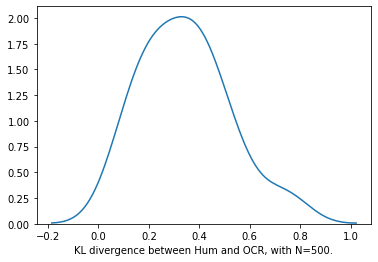

In [223]:
sns.distplot(distances, hist=False)
plt.xlabel("KL divergence between Hum and OCR, with N=%d."%top_n)

Text(0.5, 0, 'Number of words in common between Humn and OCR, with N=500.')

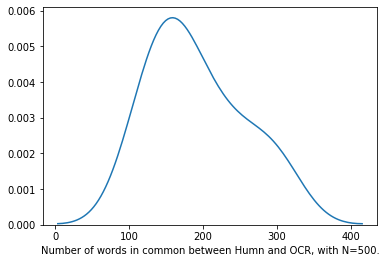

In [222]:
sns.distplot(n_words_in_common, hist=False)
plt.xlabel("Number of words in common between Humn and OCR, with N=%d."%top_n)

#### Entropy

In [224]:
# this is how to access a document's topic distrbution

sorted(model_human[corpus_human[1]],key=lambda x:x[1],reverse=True)

[(7, 0.99777657)]

In [225]:
# entropy

from scipy.stats import entropy
entropy([0.87271583, 0.12518865])

0.377647879051522

In [226]:
entropies_human = list()
for d in corpus_human:
    entropies_human.append(entropy([x[1] for x in model_human[d]]))
    
entropies_ocr = list()
for d in corpus_ocr:
    entropies_ocr.append(entropy([x[1] for x in model_ocr[d]]))

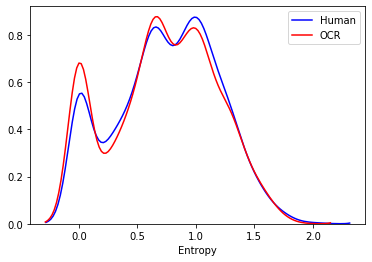

In [227]:
import seaborn as sns

sns.distplot(entropies_human, hist=False, rug=False, label="Human", color="blue")
sns.distplot(entropies_ocr, hist=False, rug=False, label="OCR", color="red")

plt.xlabel("Entropy")
plt.show()

In [228]:
from scipy.stats import ks_2samp
ks_2samp(entropies_human, entropies_ocr)

Ks_2sampResult(statistic=0.04066666666666667, pvalue=0.013572517595389402)

In [229]:
# let's do the same for the topic distribution itself, considering the top N words

# interestingly, for low top N the entropy can be higher for the human model, while for higher top N, the ocr model has consistently higher entropy.
# This might indicate that topics from the ocr model rely on fewer, proper (correct) tokens and then contain a lot of noise, while human topics are able to
# use a wider range of proper (correct) tokens. This would also explain the per-document entropy results.
# Furthermore, all ocr topics have higher entropy while human topics can have low or high entropy: effect of noise. 

top_n = 500

entropies_human_topics = list()
for t in model_human.show_topics(num_topics=-1, formatted=False, num_words=top_n):
    entropies_human_topics.append(entropy([x[1] for x in t[1]]))
    
entropies_ocr_topics = list()
for t in model_ocr.show_topics(num_topics=-1, formatted=False, num_words=top_n):
    entropies_ocr_topics.append(entropy([x[1] for x in t[1]]))

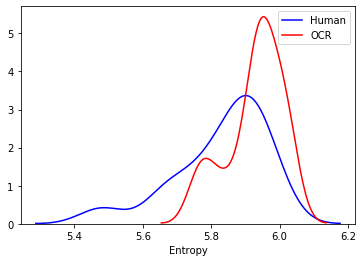

In [230]:
sns.distplot(entropies_human_topics, hist=False, rug=False, label="Human", color="blue")
sns.distplot(entropies_ocr_topics, hist=False, rug=False, label="OCR", color="red")

plt.xlabel("Entropy")
plt.show()

In [233]:
#### Number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 10, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaMulticore(corpus=corpus_human, num_topics=num_topics, id2word=dictionary_human, workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs_human, dictionary=dictionary_human, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [234]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_human, corpus=corpus_human, texts=docs_human, start=5, limit=50, step=5)

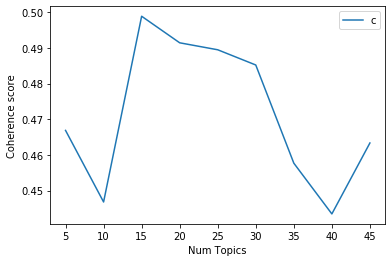

In [235]:
# Show graph
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# 10 is kinda of ok for 1000 documents, and it will probably grow sublinearly. E.g., 15 is ok for 3000 documents.

#### Manual inspection of some documents for comparison

From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

Find the most discriminative document per topic. For topic-topic matching, see above.

In [237]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords_human = format_topics_sentences(ldamodel=model_human, corpus=corpus_human, texts=docs_human)
df_topic_sents_keywords_ocr = format_topics_sentences(ldamodel=model_ocr, corpus=corpus_ocr, texts=docs_ocr)

# Format
df_dominant_topic_human = df_topic_sents_keywords_human.reset_index()
df_dominant_topic_human.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_ocr = df_topic_sents_keywords_ocr.reset_index()
df_dominant_topic_ocr.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [238]:
# Show
df_dominant_topic_human.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.8168,"ton, captain, ton_captain, agent, miss, passen...","[ship, intelligence, arrival, june, barque, to..."
1,1,7.0,0.9978,"plaintiff, defendant, state, government, new, ...","[commonwealth, note, federal, tariff, special,..."
2,2,2.0,0.5186,"year, church, sydney, school, member, man, pre...","[congregational, union, half, yearly, meeting,..."
3,3,2.0,0.9870,"year, church, sydney, school, member, man, pre...","[tudor, house, school, moss, vale, thursday, t..."
4,4,1.0,0.5019,"prisoner, charge, day, fin, police, court, pay...","[central, police, court, friday, mayor, hill, ..."
5,5,14.0,0.8078,"street, sydney, club, new, city, point, south,...","[football, rugby, union, new, zealand, team, a..."
6,6,3.0,0.7175,"new, river, car, port, motor, melbourne, gauge...","[curl, curl, drainage, trust, drainage, trust,..."
7,7,9.0,0.9912,"man, street, deceased, find, fire, body, witne...","[suicide, whinstone, valley, cooma, tuesday, i..."
8,8,2.0,0.6059,"year, church, sydney, school, member, man, pre...","[marriage, births, canberra, tuesday, issue, d..."
9,9,10.0,0.9844,"day, port, leave, vessel, ship, steamer, sydne...","[british, foreign, shipping, london, friday, a..."


In [239]:
# Show
df_dominant_topic_ocr.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5542,"court, mrs, defendant, charge, miss, day, john...","[ship, tellig, inca, arrival, june, barque, in..."
1,1,6.0,0.4198,"und, port, foi, day, waa, man, leave, old, thu...","[commonwealth, note, federal, tariff, otto, bp..."
2,2,6.0,0.8747,"und, port, foi, day, waa, man, leave, old, thu...","[congkegational, union, half, yearly, meeting,..."
3,3,13.0,0.5264,"miss, mrs, church, son, year, sydney, mis, wor...","[tudor, house, school, moss, vale, thursdaj, t..."
4,4,3.0,0.8631,"court, mrs, defendant, charge, miss, day, john...","[central, police, court, -PRON-, frida, -PRON-..."
5,5,11.0,0.5319,"mrs, john, year, sydney, son, meeting, south, ...","[football, rugby, union, new, zealand, team, a..."
6,6,0.0,0.6993,"street, railway, work, city, road, station, po...","[curl, curl, drainage, trust, drainage, trust,..."
7,7,1.0,0.6073,"man, death, find, deceased, body, police, hie,...","[suicide, whinstone, valley, cooma, tuesday, i..."
8,8,8.0,0.8394,"foi, new, man, south, wales, day, fiom, good, ...","[marriage, births, canberra, tuesday, issue, d..."
9,9,14.0,0.6287,"ton, captain, ton_captain, point, agent, port,...","[-PRON-, dritism, foreign, shippind, -PRON-, l..."


In [244]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_human = pd.DataFrame()

sent_topics_outdf_grpd_human = df_topic_sents_keywords_human.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_human:
    sent_topics_sorteddf_human = pd.concat([sent_topics_sorteddf_human, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_human.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_human.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_human

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9974,"man, time, day, good, find, great, work, water...","[australasian, france, captain, bean, official..."
1,1.0,0.9970,"prisoner, charge, day, fin, police, court, pay...","[water, police, court, thursday, water, police..."
2,2.0,0.9971,"year, church, sydney, school, member, man, pre...","[woollahra, special, record, reign, service, h..."
3,3.0,0.9960,"new, river, car, port, motor, melbourne, gauge...","[fire, damp, use, safety, lamps, annual, repor..."
4,4.0,0.9971,"john, year, james, bull, company, son, service...","[agricultural, tenterfield, tenterfield, tuesd..."
5,5.0,0.9960,"court, charge, case, accuse, guilty, john, day...","[wilcannia, quarter, session, wilcannia, wedne..."
6,6.0,0.9968,"miss, mrs, lady, hall, wear, john, party, sydn...","[easter, dance, kindergarten, union, eighteen,..."
7,7.0,0.9978,"plaintiff, defendant, state, government, new, ...","[commonwealth, note, federal, tariff, special,..."
8,8.0,0.9965,"play, score, run, wicket, match, goal, ball, w...","[british, association, rule, round, connection..."
9,9.0,0.9980,"man, street, deceased, find, fire, body, witne...","[casualty, saturday, morning, dead, body, youn..."


In [245]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_ocr = pd.DataFrame()

sent_topics_outdf_grpd_ocr = df_topic_sents_keywords_ocr.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_ocr:
    sent_topics_sorteddf_ocr = pd.concat([sent_topics_sorteddf_ocr, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_ocr.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_ocr.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_ocr

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9968,"street, railway, work, city, road, station, po...","[meeting, parliamentary, standing, committee, ..."
1,1.0,0.9963,"man, death, find, deceased, body, police, hie,...","[coroner, court, late, -PRON-, oisoninq, josse..."
2,2.0,0.9970,"pte, foi, mrs, bull, cow, miss, heifer, black,...","[agricultural, tenterfield, tenterfield, tuesd..."
3,3.0,0.9969,"court, mrs, defendant, charge, miss, day, john...","[-PRON-, cenfral, police, court, -PRON-, tuesd..."
4,4.0,0.9980,"petitioner, respondent, nisi, honor, grant, de...","[divorce, judge, divorce, justice, boyce, bate..."
5,5.0,0.9974,"aro, havo, man, water, boat, day, find, time, ...","[lister, pictures, attractive, lister, lister,..."
6,6.0,0.9967,"und, port, foi, day, waa, man, leave, old, thu...","[state, politics, confused, position, governme..."
7,7.0,0.9953,"club, play, man, win, match, miss, team, good,...","[cricket, tho, fourth, iinnual, nicotine, tho,..."
8,8.0,0.9961,"foi, new, man, south, wales, day, fiom, good, ...","[letter, aborigines, dog, editor, herald, -PRO..."
9,9.0,0.9943,"new, foi, day, year, night, acre, child, man, ...","[new, guinea, mission, meeting, hold, monday, ..."
